In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan, linewidth=np.nan)

In [2]:
id_name = ['diningtable', 'chair', 'sofa', 'bottle', 'pottedplant', 'tvmonitor', 'train', 'bus', 'car',
           'bicycle', 'motorbike', 'aeroplane', 'boat', 'cow', 'horse', 'sheep', 'dog', 'cat', 'bird',
           'person', 'household', 'furniture', 'transport', 'land_transport', 'animal', 'livestock', 'pet']
N = len(id_name)
name_id = dict(zip(id_name, range(0, N)))

In [3]:
def read_hierarchy(filename):
    """
    Parses a hierarchy file of concepts. Subsumption is denoted by \t.
    A tree-shaped hierarchy should be avoided, as tree is too nice in some properties.
    Currently the hierarchy is a forest with overlapping leaf nodes, making it maximally sparse by default.
    Returns:
        g: hierarchy graph as an adjacency matrix
    """
    with open(filename, mode='r') as h:
        lines = h.read().splitlines()
    g = np.zeros((N, N), dtype=bool)
    stack = list()
    for x in lines:
        depth = x.count('\t', 0, len(x) - len(x.lstrip()))
        name = x.strip()
        if depth < len(stack) - 1:  # arbitrary levels shallower
            del stack[depth:]  # pop until len(stack)==depth
        if depth == 0 and len(stack) == 0:  # root node
            stack.append(name)
        elif depth == len(stack):  # one level deeper
            from_id = name_id[stack[-1]]
            to_id = name_id[name]
            g[from_id, to_id] = True
            stack.append(name)
        elif depth == len(stack) - 1:  # same level
            from_id = name_id[stack[-2]]
            to_id = name_id[name]
            g[from_id, to_id] = True
            stack[-1] = name
        else:  # arbitrary levels shallower, but haven't reached root
            from_id = name_id[stack[-1]]
            to_id = name_id[name]
            g[from_id, to_id] = True
            stack.append(name)
    return g

In [4]:
H = read_hierarchy('hierarchy_full.txt')  # H for hierarchy (directed) subgraph

In [5]:
# debug functions
def print_bool_matrix(m):  # np.set_printoptions(threshold=np.nan, linewidth=np.nan)
    print(np.array_str(m.astype(np.uint8)))
def print_edges(g):  # defined outside: id_name
    edges = set()
    for x, y in np.argwhere(g):
        if g[y, x]:
            key1 = '{} <-> {}'.format(id_name[x], id_name[y])
            key2 = '{} <-> {}'.format(id_name[y], id_name[x])
            if key1 not in g and key2 not in g:
                edges.add(key1)
        else:
            edges.add('{} -> {}'.format(id_name[x], id_name[y]))
    print('\n'.join(edges))

In [6]:
from scipy.sparse.csgraph import floyd_warshall
H_ts = floyd_warshall(H, unweighted=True) != np.inf  # H_ts for transitive closure of H with self-loops
H_t = H_ts - np.eye(N, dtype=bool)  # H_t for transitive closure of H without self-loops

In [7]:
def build_exclusion(H_ts):
    """
    Builds exclusion subgraph from hierarchy. Two nodes are exclusive unless they share a common descendant.
    Args:
        H_ts: Transitive closure of hierarchical subgraph with self-loop. Self-loop is mandatory as the common descendant of two nodes may be one of them.
    """
    n = H_ts.shape[0]
    g = np.ones((N, N), dtype=bool) - np.eye(N, dtype=bool)  # fully connected by default
    for i in range(0, n):
        for j in range(i + 1, N):
            if np.logical_and(H_ts[i], H_ts[j]).any():  # if two nodes share a descendant, then unconnect
                g[i, j] = g[j, i] = False
    return g

In [8]:
EX = build_exclusion(H_ts)  # EX for exclusion (undirected) subgraph

In [9]:
def dfs_connected(g, from_id, to_id):
    def dfs(at_id):  # defined outside: visited
        if at_id == to_id:
            return True
        visited[at_id] = True
        for x in np.nonzero(g[at_id])[0]:  # nodes that can be visited from @at_id
            if not visited[x] and dfs(x):
                return True
        return False
    visited = np.zeros(N, dtype=bool)
    return dfs(from_id)

In [10]:
def sparsify(g, edges):
    """
    For each undirected edge (x, y), if both directions are still connected without (x, y), then (x, y) is removed.
    This algorithm does not guarantee maximal sparsity. See counter-example on Deng et al, page 8.
    Approximating |E| by |V|^2, this brute-force solution has complexity O(|V|^3).
    Args:
        edges: iterable<tuple<int, int>>
    """
    for x, y in edges:
        m = np.copy(g)
        m[x, y] = m[y, x] = False
        if dfs_connected(m, x, y) and dfs_connected(m, y, x):
            g[x, y] = g[y, x] = False
    return g

In [11]:
HEX_sparse = sparsify(H + EX, np.argwhere(EX))  # recall that @H is already maximally sparse
HEX_dense = H_t + EX - np.eye(N, N, dtype=bool)  # recall that @EX is already maximally dense

In [12]:
def build_state_space(H_t, EX):
    """
    Lists the state space of a HEX graph. Algorithm based on Deng et al, page 9
    1. Find a node without in-edges in the hierarchy subgraph as the seed.
    2. In a recursive divide-and-conquer manner, assign the pivot as true/false.
    3. In each recursive step:
        3.1. find a node in the partially assigned state that has not been assigned a value,
            but all its ancestors have. If all its ancestors are True, then this node is True-able.
        3.2. Assigning True to a node means all nodes exclusive to it are false.
        3.3. Assigning False to a node means all its offsprings are false.
    """
    def find_pivot(pas):  # find a node whose ancestors have all been assigned a value, but itself hasn't
        for i in np.where(pas == 0)[0]:
            ancestors = np.where(H_t[:, i])[0]
            if np.all(pas[ancestors]):
                true_able = np.all(pas[ancestors] == 1) or ancestors.size == 0
                return i, true_able  # the pivot can be true only if all its ancestors are true

    def bss_step(pas):  # pas for partially assigned state
        if np.count_nonzero(pas) == N:  # if all variables have been assigned a value
            return {tuple(pas)}
        p, true_able = find_pivot(pas)
        p_false = pas.copy()
        p_false[p] = -1  # pivot is false. Nodes exclusive to the pivot are free
        p_false[np.where(H_t[p][0])] = -1  # all offsprings of the pivot are false
        if true_able:
            p_true = pas.copy()
            p_true[p] = 1  # pivot is true. Immediate children of the pivot are free
            p_true[np.where(EX[p])[0]] = -1  # nodes exclusive to the pivot are false
            return bss_step(p_true).union(bss_step(p_false))
        return bss_step(p_false)

    s = np.where(H_t.sum(axis=0) == 0)[0][0]  # pick any node without in-edges in @H_t as the seed
    s_true = np.zeros(N, dtype=int)  # 0 for free variable, 1 for true, -1 for false
    s_true[s] = 1
    s_false = np.zeros(N, dtype=int)
    # must not write 'seed_true = seed_false = ...', as the two variables would point to the same object
    s_false[s] = -1
    state_space = bss_step(s_true).union(bss_step(s_false))
    state_space.remove(tuple(np.ones(N, dtype=int) * -1))
    return np.array(list(state_space)) > 0

In [13]:
# debug function
def print_state_space(state_space):
    print('size=' + str(len(state_space)))
    for x in state_space:
        print([id_name[i] for i in range(0, len(x)) if x[i] == 1])

In [14]:
state_space = build_state_space(H_t, EX)
print_state_space(state_space)

size=27
['animal', 'livestock']
['transport', 'land_transport']
['pottedplant', 'household']
['boat', 'transport']
['cow', 'animal', 'livestock']
['chair', 'household', 'furniture']
['household', 'furniture']
['bottle', 'household']
['bus', 'transport', 'land_transport']
['car', 'transport', 'land_transport']
['animal']
['horse', 'animal', 'livestock']
['tvmonitor', 'household']
['person', 'animal']
['transport']
['animal', 'pet']
['household']
['sheep', 'animal', 'livestock']
['bird', 'animal', 'pet']
['bicycle', 'transport', 'land_transport']
['diningtable', 'household', 'furniture']
['train', 'transport', 'land_transport']
['cat', 'animal', 'pet']
['dog', 'animal', 'pet']
['sofa', 'household', 'furniture']
['motorbike', 'transport', 'land_transport']
['aeroplane', 'transport']


In [15]:
def build_hierarchical_labels(H_ts, state_space):
    """
    For each node, finds in the state space, all legal states of its ancestors, except for the all-False trivial state.
    For each such states, the set of active (True) ancestors of that node forms one of its hierarchical labels.
    Returns:
        id_hierarchical_labels: list<list<tuple<id>>>, used as dict<id, list<tuple<id>>>
    """
    id_hierarchical_labels = list()
    for i in range(0, N):
        active_ances = list()  # list<tuple<id>>
        ances_id = np.nonzero(H_ts[:, i])[0]
        for s in set(map(tuple, state_space[:, ances_id])):  # for each unique state of ancestors
            aas = filter(lambda x: x[1], zip(ances_id, s))  # retains active ancestors. aas for active ancestor state
            if aas:  # if ancestors are not all inactive (trivial state)
                active_ances.append(zip(*aas)[0])  # label of active ancestors
        id_hierarchical_labels.append(active_ances)
    return id_hierarchical_labels

In [16]:
id_hls = build_hierarchical_labels(H_ts, state_space)

In [17]:
import pickle
data = {'id_name': id_name, 'name_id': name_id, 'H': H, 'H_t': H_t, 'HEX_sparse': HEX_sparse,
        'HEX_dense': HEX_dense, 'state_space': state_space, 'id_hierarchical_labels': id_hls}
with open('cache/hex.pickle', mode='wb') as h:
    pickle.dump(data, h)

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
def visualize(m, directed):
    g = nx.DiGraph() if directed else nx.Graph()
    g.add_nodes_from(id_name)
    xs, ys = np.nonzero(m)
    xs = map(lambda x: id_name[x], xs)
    ys = map(lambda x: id_name[x], ys)
    g.add_edges_from(zip(xs, ys))
    # nx.write_dot(g, 'plot.dot')
    plt.figure(figsize=(10, 8))
    nx.draw(g, pos=nx.spring_layout(g), node_color='white', node_size=2000, with_labels=True)
    plt.show()

Couldn't import dot_parser, loading of dot files will not be possible.


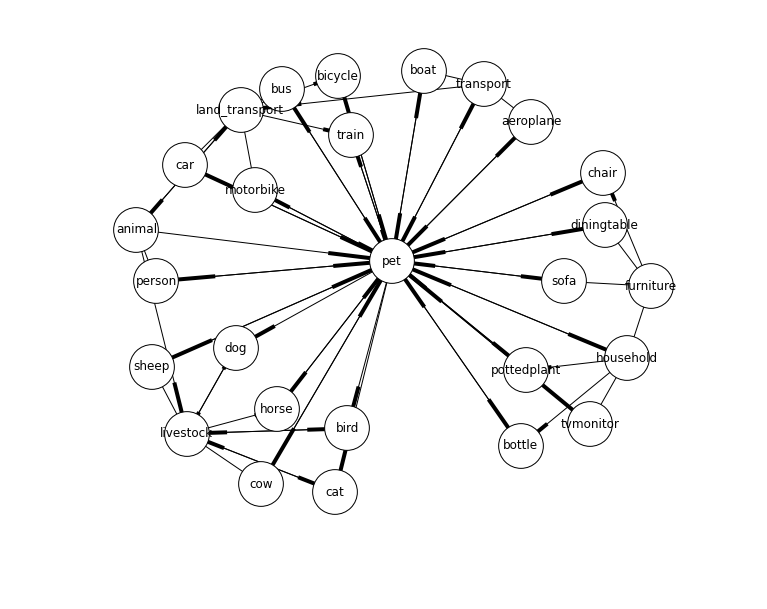

In [19]:
visualize(HEX_sparse, True)